In [1]:
### import os
import numpy as np
import glob
import csv
import matplotlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
import scipy
import sys
import pickle
from scipy.optimize import minimize
from IPython.parallel import Client
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
rc = Client()

In [3]:
home_dir = '/Users/ianballard/Dropbox/two_step_analysis/' #where the data live
path = home_dir + '/modeling/'

ignore_files = ['bonuses.csv','A1DS5O8MSI3ZH0.csv','A2C39KTRMOM1XZ.csv','all_data.csv']
data_files = glob.glob(home_dir + '*csv')
data_files = [d for d in data_files if d.split('/')[-1] not in ignore_files]
sub_ids = map(lambda f: f.split('/')[-1].split('.csv')[0],data_files)
print(len(data_files))

101


In [4]:
data_f = home_dir + 'all_data.csv'
if True:
    ntrials = 200 
    key_map = {37:0,39:1} #keystrokes. Remember that the location of the stimuli changes trial to trial
    state_map = {'3,2':'b','5,4':'c','2,3':'b','4,5':'c'} #
    choice_map = {2:'0',3:'1',4:'0',5:'1'}
    practice = ['practice_first_stage', 'practice_second_stage', 'practice_FB_stage'] #labels for practice trials
    missed_responses = {}
    key_presses = {}
    all_data = []

    for i,f in enumerate(data_files):
        if True:
            sub_id = sub_ids[i] #parse subid from filename
            missed_responses[sub_id] = 0
            key_presses[sub_id] = []

            #dictionary to fill. Shift rew and ttype so [rew,ttype][n-1] corresponds to stay[n].
            data = {'rt1':[],'rt2':[],'action1':[],'action2':[],'choice1':[],
                    'choice2':[],'state':[],'rew':[],'ttype':[],'stay':[],
                    'sub':[]} 

            #preprocess data
            df = pd.read_csv(f) 
            df = df.drop(['view_history','stimulus','internal_chunk_id'],1) #drop useless columns

            #drop practice trials
            for t in practice: 
                df = df[df['trial_id'] != t]

            #get choices, actions, rewards, RTs, etc from each trial
            for i in range(ntrials): 
                trial_df = df[df['trial_num'] == i] #get data corresponding to that trial
                if len(trial_df) == 3 and trial_df['key_press'].values[0] != -1 and trial_df['key_press'].values[1] != -1: 
                    state = state_map[str(trial_df['condition'].values[1])]
                    data['rt1'].append(trial_df['rt'].values[0])
                    data['rt2'].append(trial_df['rt'].values[1])
                    data['rew'].append(float(trial_df['condition'].values[2])) 
                    data['state'].append(state)

                    key_presses[sub_id].extend(trial_df['key_press'].values[0:2]) #to check for random responding
                    action1 = key_map[trial_df['key_press'].values[0]]
                    action2 = key_map[trial_df['key_press'].values[1]]
                    choice1 = trial_df['condition'].values[0].split(',')[action1]
                    choice2 = choice_map[int(trial_df['condition'].values[1].split(',')[action2])]

                    #determine if it was a switch or stay trial
                    if len(data['choice1'])>0 and (choice1 == data['choice1'][-1]):
                        data['stay'].append('stay')
                    else:
                        data['stay'].append('switch')

                    #add values to dictionary
                    data['action1'].append(action1)
                    data['action2'].append(action2)
                    data['choice1'].append(choice1)
                    data['choice2'].append(choice2)

                    #determine if it was a common or rare transition
                    if (choice1 == 0 and state == 'b') or (choice1 == 1 and state == 'c'):
                        data['ttype'].append('common')
                    else:
                        data['ttype'].append('rare')
                else:
                    missed_responses[sub_id] +=1

            data['sub'] = [sub_id] * len(data['rt1'])
            data = pd.DataFrame(data) #make dataFrame
            all_data.append(data)
    print len(all_data)   
    all_data = pd.concat(all_data)
    all_data.to_csv(data_f,index = False)

101


# Subject Exclusions

In [5]:
# #checks is a big list contains a small list
# def contains(small, big):
#     for i in xrange(len(big)-len(small)+1):
#         for j in xrange(len(small)):
#             if big[i+j] != small[j]:
#                 break
#         else:
#             return i, i+len(small)
#     return False

In [6]:
# bad_subs = set()

In [7]:
# #random responding
# bad_length = 20
# bad_strings = [[37.0]*bad_length,[39.0]*bad_length, [37.0,39.0] *(bad_length/2)]

# for s in sub_ids:
#     for bad_str in bad_strings:
#         if contains(bad_str,key_presses[s]):
#             bad_subs.add(s)

In [8]:
# #missed responses
# for s in missed_responses.keys():
#     if missed_responses[s] > 10:
#         bad_subs.add(s)

In [9]:
# #drop bad subjects
# sub_ids = [s for s in sub_ids if s not in bad_subs]
# print len(sub_ids)

In [10]:
# remake into a list of subject data for parallel model fitting
data_list = map(lambda x: all_data[all_data['sub'] == x], sub_ids)

# Helper Functions

In [11]:
def calc_bic(ll,n_params,n_obs):
    return 2*ll + n_params*np.log(n_obs)

In [12]:
def calc_aicc(ll,n_params,n_obs):
    return 2*ll + 2*n_params + (2*n_params * (n_params+1))/(n_obs*1.0 - n_params -1)

In [13]:
def llrt_null(LL,num_choices,param_diff):
    diff = 2*(LL - np.log(.5)*num_choices)
    return scipy.stats.chi2.sf(diff, param_diff)

In [14]:
def llrt(LL,LL_null,nparams,nparams_null):
    param_diff = nparams - nparams_null
    diff = 2*(LL - LL_null)
    return scipy.stats.chi2.sf(diff, param_diff)

In [15]:
#get probability of each action under the softmax
def get_prob(Q,m): 
    probs = map(lambda q: np.exp(q*m), Q)
    probs = probs / np.sum(probs)
    return probs

In [16]:
#drop subjects who dont fit
def drop_bad_subs(results_df,models,model_prefix,param_map):
    bad_subs = set()
    for m in models:
        model_df = results_df[results_df['model'] == model_prefix + m]
        LL = model_df['LL'].values
        model_df['llrt'] = map(lambda x: llrt_null(-1*x,199*2,param_map[m]),LL)
        bad_subs.update(model_df[model_df['llrt'] > .05]['sub'].values)
    
    for sub in bad_subs:
        results_df = results_df[results_df['sub'] != sub]
    
    return results_df, bad_subs

# Associative Model

In [17]:
#every time a transition occurs, increment the association between those two objects
def update_associations(state,new_state,action,associations, actions):
    for a in actions:
        associations[state + action][new_state + a] = associations[state + action][new_state + a] + 1
        associations[new_state + a][state + action] = associations[state + action][new_state + a] #make symmetric  
    return associations

In [18]:
#normalize association matrix
def norm_associations(associations):
    norm_assoc = {}
    for a in associations.keys():
        total = sum(associations[a].itervalues()) * 1.0 #sum of associations
        if total != 0:
            norm_assoc[a] = {k: v/total for k, v in associations[a].items()}
    return norm_assoc

In [19]:
def update_value(alpha,eligibility,rew,state,new_state,action,V,associations):
    delta = rew - V[state+action]
    V[state+action] = V[state+action] + alpha*delta
    
    norm_assoc = norm_associations(associations)
    #percolate value one step back, weighted by the strength of association
    for o in norm_assoc[state+action]:
        delta = rew - V[o]
        V[o] = V[o] + norm_assoc[state+action][o] * alpha * delta * eligibility
    return V

In [20]:
#get the appropriate parameters for the model type
def get_model_params_assoc(params,model):
    alpha,persev,eligibility,m1,m2 = params
        
    if model == '1m':
        m2 = m1
    elif model == 'no_elig':
        eligibility = 1
    elif model == 'no_persev':
        persev = 0
        
    return alpha,persev,eligibility,m1,m2

In [21]:
def sub_LL(params,sub_data,model):
    alpha,persev,eligibility,m1,m2 = get_model_params_assoc(params,model)

    #initialize state space
    objects = ['a0','a1','b0','b1','c0','c1']
    states = ['a','b','c','terminal']
    actions = ['0','1']

    associations = {o1: {o2 : 0 for o2 in objects if o1!=o2} for o1 in objects}
    V = {key: 0 for key in objects}
    
    #loop through trials
    LL = 0
    for i in range(len(sub_data)):
        #extract some useful variables
        trial_data = sub_data.ix[i]
        choice1 = int(trial_data['choice1'])
        choice2 = int(trial_data['choice2'])
        state2 = trial_data['state']
        rew = trial_data['rew']
        
        #first level prob
        #add in perseveration parameter 
        values = [V['a0'],V['a1']]
        if trial_data['stay'] == 'stay':
            values[choice1] = values[choice1] + persev
        else:
            values[1 - choice1] = values[1 - choice1] + persev
            
        first_level_probs = get_prob(values,m1)
        choice_prob = first_level_probs[choice1]
        LL += np.log(choice_prob)

        #second level prob
        if state2 == 'b':
            second_level_probs = get_prob([V['b0'],V['b1']],m2)
        elif state2 == 'c':
            second_level_probs = get_prob([V['c0'],V['c1']],m2)
        
        choice_prob = second_level_probs[choice2]
        LL += np.log(choice_prob)
        
        #update associations and value
        associations = update_associations('a',state2,str(choice1),associations,actions) #update associations
        V = update_value(alpha,eligibility,rew,state2,'terminal',str(choice2),V,associations)
    
    LL = LL * -1 #minimize negative LL    
    return LL
sub_data = all_data[all_data['sub'] == sub_ids[0]]
sub_LL([.1,.5,1,3,5],sub_data,'no_elig')

331.22731100888376

In [25]:
def run_sub(in_tuple):
    sub_data, model = in_tuple
    sub_id = sub_data['sub'][0]
    sub_data = sub_data.reset_index(drop=True)
    out_f = path + sub_id + '_assoc_' + model
    
    if not os.path.exists(out_f):
        params = [.5,0,.5,1,1] #alpha,persev,eligibility,m1,m2 

        bounds = ((0.01,1),(-20,20),(0,1),(0.01,20),(0.01,20))

        res = minimize(sub_LL,params,args=(sub_data,model),options={'disp': False},bounds = bounds)
        pickle.dump(res, open(out_f, "wb"))
    return (str(sub_id),model)

# run_sub(in_tuples[0])

In [26]:
#fit models in parallel
dview = rc[:]
dview.block=True
dview.push(dict(update_associations=update_associations,
                sub_LL=sub_LL,
                get_prob=get_prob,
               update_value = update_value,
                get_model_params_assoc = get_model_params_assoc,
               norm_associations = norm_associations,
               path = path))
dview.execute("import numpy as np")
dview.use_dill()  # Standard pickle fails with functions
with dview.sync_imports():
    import os
    import numpy
    import pandas as pd
    from pandas import DataFrame, Series
    import scipy
    from scipy.optimize import minimize
    import pickle
    
#fit lots of models
output1 = []
models = ['std','1m','no_elig','no_persev']
for m in models:
    in_tuples = [(x,m) for x in data_list]
    output1.extend(dview.map_sync(run_sub,in_tuples))

<module 'ipyparallel.serialize' from '//anaconda/lib/python2.7/site-packages/ipyparallel/serialize/__init__.pyc'>
importing os on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing DataFrame,Series from pandas on engine(s)
importing scipy on engine(s)
importing minimize from scipy.optimize on engine(s)
importing pickle on engine(s)


In [39]:
models = ['std','1m','no_elig','no_persev']
results_assoc = {'LL':[],'alpha':[],'m1':[],'m2':[],'persev':[],'eligibility':[],'sub':[],'model':[]}
for m in models:
    for o in sub_ids:
        res = pickle.load(open(path + o + '_assoc_' + m, "rb" ))

        if type(res) is not float:
            results_assoc['sub'].append(o)
            results_assoc['model'].append('assoc_' + m)
            results_assoc['LL'].append(res.fun)
            results_assoc['alpha'].append(res.x[0])
            results_assoc['persev'].append(res.x[1])
            results_assoc['eligibility'].append(res.x[2])
            results_assoc['m1'].append(res.x[3])
            results_assoc['m2'].append(res.x[4])
            
results_assoc = pd.DataFrame(results_assoc)

# LLRT within assoc class

In [28]:
#drop subjects who dont fit
param_map = {'std':5,'1m':4,'no_elig':4,'no_persev':4}
results_assoc = drop_bad_subs(results_assoc,param_map.keys(),'_assoc',param_map)

In [29]:
total_ll = {}
for m in models:
    model_df = results_assoc[results_assoc['model'] == 'assoc_' + m]
    total_ll[m] = sum(model_df['LL'].values)*-1
    nsubs = len(model_df)
print nsubs
print total_ll

TypeError: tuple indices must be integers, not str

In [30]:
llrt(total_ll['std'],total_ll['1m'],5*nsubs,4*nsubs)

KeyError: 'std'

# Model-Based / Model-Free model

In [31]:
def update_value_mf(alpha,rew,state,new_state,action1,action2,Q):
    delta = rew + Q[new_state][action2] - Q[state][action1]
    Q[state][action1] = Q[state][action1] + alpha*delta
    return Q,delta

In [32]:
def eligibility_trace_update(alpha,eligibility,state,action,Q,delta):
    Q[state][action] = Q[state][action] + eligibility*alpha*delta
    return Q

In [33]:
#heuristic for getting transition matrix
def get_transition_matrix(transition_count):
    count1 = transition_count[0]['b'] + transition_count[1]['c']
    count2 = transition_count[1]['b'] + transition_count[0]['c']

    if count1 > count2:
        transitions = {0:{'b':.7,'c':.3},1:{'b':.3,'c':.7}}
    else:
        transitions = {0:{'b':.3,'c':.7},1:{'b':.7,'c':.3}}

    return transitions

In [34]:
#get the appropriate parameters for the model type
def get_model_params_mbmf(params,model):
    alpha1,alpha2,eligibility,persev,w,m1,m2 = params #full model
        
    if model == '1alpha':
        alpha2 = alpha1
    elif model == '1m':
        m2 = m1
    elif model == '1alpha_1m':
        alpha2 = alpha1
        m2 = m1
    elif model == 'no_elig':
        eligibility = 0
    elif model == 'no_persev':
        persev = 0
        
    return alpha1,alpha2,eligibility,persev,w,m1,m2

In [35]:
def sub_LL_MB_MF(params,sub_data,model):

    alpha1,alpha2,eligibility,persev,w,m1,m2 = get_model_params_mbmf(params,model)
    
    #initialize state space
    states = ['a','b','c','terminal']
    actions = [0,1]
    transition_count = {0:{'b':0,'c':0},1:{'b':0,'c':0}}
    Q_mf = {key: [0,0] for key in states}
    
    #loop through trials
    nsteps = 0
    LL = 0
    for i in range(len(sub_data)):
        
        #extract some useful variables
        trial_data = sub_data.ix[i]
        choice1 = int(trial_data['choice1'])
        choice2 = int(trial_data['choice2'])
        state2 = trial_data['state']
        rew = trial_data['rew']

        #compute Q_mb first!
        Q_mb = []
        transition_matrix = get_transition_matrix(transition_count)
        for a in actions:
            mb = max(Q_mf['b']) * transition_matrix[a]['b'] + max(Q_mf['c']) * transition_matrix[a]['c']
            Q_mb.append(mb)

        #compute choice likelihoods
        if i > 0: #don't bother with first trial. Complicates perseveration analysis
            #compute choice probabilities for the first level
            mixed_Q = (1-w)*np.array(Q_mf['a']) + w*np.array(Q_mb)

            #add in perseveration parameter 
            if trial_data['stay'] == 'stay':
                mixed_Q[choice1] = mixed_Q[choice1] + persev
            else:
                mixed_Q[1 - choice1] = mixed_Q[1 - choice1] + persev

            choice_prob = get_prob(mixed_Q,m1)[choice1]
            LL += np.log(choice_prob)

            #compute choice probabilities for the second level
            choice_prob = get_prob(Q_mf[state2],m2)[choice2]
            LL += np.log(choice_prob)

        #update Q_mf
        Q_mf, delta1 = update_value_mf(alpha1,0.0,'a',state2,choice1,choice2,Q_mf) #first stage
        Q_mf, delta2 = update_value_mf(alpha2,rew,state2,'terminal',choice2,0,Q_mf) #second stage
        Q_mf = eligibility_trace_update(alpha1,eligibility,'a',choice1,Q_mf,delta2) #eligibility trace

        #keep track of transitions
        transition_count[choice1][state2] += 1

    LL = LL*-1
    return LL

sub_data = all_data[all_data['sub'] == sub_ids[3]]
sub_data = sub_data.reset_index(drop=True)
# sub_LL_MB_MF([.7,.9,.5,.9,3,3],sub_data)
sub_LL_MB_MF([0.0 ,.2,1.0 ,20.0, 0.0, 9.10815663499 ,3.94114954613],sub_data,'std')


7058.8008675620349

In [36]:
def run_sub_mbmf(in_tuple):
    sub_data, model = in_tuple
    sub_data = sub_data.reset_index(drop=True)
    sub_id = sub_data['sub'][0]
    out_f = path + sub_id + '_mbmf_' + model
    
    if not os.path.exists(out_f):
        params = [.5,.5,.5,0,.5,1,1] #alpha1,alpha2,eligibility,persev,w,m1,m2
        bounds = ((0.01,1),(.01,1),(0,1),(-20,20),(0,1),(0.01,20),(0.01,20))
        res = minimize(sub_LL_MB_MF,params,args=(sub_data,model),options={'disp': True},bounds = bounds)
        pickle.dump(res, open(out_f, "wb" ))
    
    return (str(sub_id),model)
# run_sub_mbmf(in_tuples[10])

In [37]:
#fit models in paralell
dview = rc[:]
dview.block=True
dview.push(dict(run_sub_mbmf = run_sub_mbmf,
                update_value_mf=update_value_mf,
                sub_LL_MB_MF=sub_LL_MB_MF,
                get_prob=get_prob,
                get_model_params_mbmf = get_model_params_mbmf,
               eligibility_trace_update = eligibility_trace_update,
               get_transition_matrix = get_transition_matrix,
               path = path))
dview.execute("import numpy as np")
dview.use_dill()  # Standard pickle fails with functions
with dview.sync_imports():
    import numpy
    import pandas as pd
    from pandas import DataFrame, Series
    import scipy
    from scipy.optimize import minimize
    import pickle

#fit lots of models
output2 = []
models = ['std','1alpha','1m','1alpha_1m','no_elig','no_persev']
for m in models:
    in_tuples = [(x,m) for x in data_list]
    output2.extend(dview.map_sync(run_sub_mbmf,in_tuples))

<module 'ipyparallel.serialize' from '//anaconda/lib/python2.7/site-packages/ipyparallel/serialize/__init__.pyc'>
importing numpy on engine(s)
importing pandas on engine(s)
importing DataFrame,Series from pandas on engine(s)
importing scipy on engine(s)
importing minimize from scipy.optimize on engine(s)
importing pickle on engine(s)


In [38]:
#parse pickled results from parallel execution
results_mbmf = {'LL':[],'alpha1':[],'alpha2':[],'eligibility':[],'persev':[],
                'w':[],'m1':[],'m2':[],'sub':[],'model':[]}
models = ['std','1alpha','1m','1alpha_1m','no_elig','no_persev']
for m in models:
    for o in sub_ids:
        res = pickle.load(open(path + o + '_mbmf_' + m, "rb" ))
        results_mbmf['model'].append('mbmf_' + m)
        results_mbmf['sub'].append(o)
        results_mbmf['LL'].append(res.fun)
        results_mbmf['alpha1'].append(res.x[0])
        results_mbmf['alpha2'].append(res.x[1])
        results_mbmf['eligibility'].append(res.x[2])
        results_mbmf['persev'].append(res.x[3])
        results_mbmf['w'].append(res.x[4])
        results_mbmf['m1'].append(res.x[5])
        results_mbmf['m2'].append(res.x[6])
results_mbmf = pd.DataFrame(results_mbmf)


# Do LLRTs within MB/MF class

In [70]:
#drop subjects who dont fit
param_map = {'std':7,'1alpha':6,'1m':6,'1alpha_1m':5,'no_elig':6,'no_persev':6}
results_mbmf, bad_subs = drop_bad_subs(results_mbmf,param_map.keys(),'mbmf_',param_map)
print len(bad_subs)

21


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
total_ll = {}
for m in models:
    model_df = results_mbmf[results_mbmf['model'] == 'mbmf_' + m]
    total_ll[m] = sum(model_df['LL'].values)*-1
    nsubs = len(model_df)
print total_ll

{'std': -11619.928040443709, 'no_persev': -11893.866567211835, 'no_elig': -11815.928065952574, '1alpha': -11637.961788393655, '1alpha_1m': -11755.518285866778, '1m': -11723.923685294323}


In [47]:
llrt(total_ll['std'],total_ll['no_elig'],7*nsubs,6*nsubs)

2.325191688956401e-52

# Perform Bayesian Model Comparison

In [41]:
best1 = results_assoc[results_assoc['model'] == 'assoc_std'].copy()
best1['model'] = 'assoc'
best2 = results_mbmf[results_mbmf['model'] == 'mbmf_1alpha'].copy()
best2['model'] = 'mbmf'
results = pd.concat([best1,best2])
results = results.sort(['model','sub'])

# results = results.sort(['sub','model'])
# print results[['LL','model']]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [42]:
#drop subjects who dont fit
param_map = {'mbmf':6,'assoc':5}
results, bad_subs = drop_bad_subs(results,param_map.keys(),'',param_map)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
#write to text file
path = '/Users/ianballard/Dropbox/two_step_analysis/modeling2/';
for m in set(results['model'].values):

    n_params = param_map[m]

    total_ll = results[results['model'] == m]['LL'].values
    aic = map(lambda x: calc_aicc(x,n_params,120),total_ll)
    bic = map(lambda x: calc_bic(x,n_params,120),total_ll)
    
    print len(aic)

    np.savetxt(path + m + '_aic',aic)
    np.savetxt(path + m + '_bic',bic)

78
78


In [44]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-9eca42f6-8139-4e85-8fd5-ac97a6caa122
Send 'exit' command to kill the server
.....................MATLAB started and connected!


//anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


In [45]:
%%matlab -o pxp_b
path = '/Users/ianballard/Dropbox/two_step_analysis/modeling2/';
ic = '_bic';
mbmf = textread([path,'mbmf',ic]);
ass = textread([path,'assoc',ic]);
lc = [mbmf,ass];
lc = lc*-1;
[alpha,exp_r,xp,pxp_b,bor] = spm_BMS(lc);

In [46]:
%%matlab -o pxp_a
path = '/Users/ianballard/Dropbox/two_step_analysis/modeling2/';
ic = '_aic';
mbmf = textread([path,'mbmf',ic]);
ass = textread([path,'assoc',ic]);
lc = [mbmf,ass];
lc = lc*-1;
[alpha,exp_r,xp,pxp_a,bor] = spm_BMS(lc);

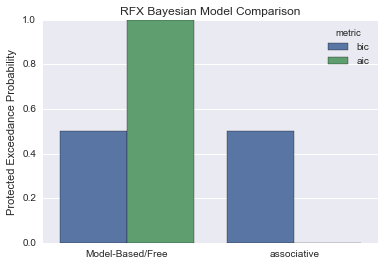

In [47]:
model = ['Model-Based/Free','associative']

xp_df = pd.DataFrame({'model':model*2,
                      'Protected Exceedance Probability':list(pxp_b[0]) + list(pxp_a[0]),
                     'metric':['bic']*len(model) + ['aic']*len(model) })
sns.barplot(x = 'model', y = 'Protected Exceedance Probability',hue = 'metric',data = xp_df)
plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance Probability')
plt.xlabel('')
plt.savefig(home_dir + '/figures/model_fit.png',dpi=600)

In [90]:
results.sort(['sub','model'])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,LL,alpha,alpha1,alpha2,eligibility,m1,m2,model,persev,sub,w
0,269.064463,0.031964,NaN,NaN,0.188939,0.010000,6.062521,assoc,-3.104816e+00,A002160837SWJFPIAI7L7,NaN
76,267.690743,NaN,0.031991,0.5,1.000000,0.010000,6.057720,mbmf,-2.040388e+00,A002160837SWJFPIAI7L7,1.000000
1,251.531246,0.605971,NaN,NaN,1.000000,0.855349,1.598755,assoc,5.019329e-01,A12DBV9FNAOFEM,NaN
77,247.402409,NaN,0.567820,0.5,0.101579,2.615283,1.659696,mbmf,1.479927e-01,A12DBV9FNAOFEM,0.680002
2,212.804578,0.013201,NaN,NaN,0.320412,5.392806,5.156650,assoc,2.289448e-01,A138BU1VWM2RKN,NaN
78,210.278897,NaN,0.026686,0.5,1.000000,7.299318,3.505943,mbmf,1.682433e-01,A138BU1VWM2RKN,0.773550
4,111.268862,0.421723,NaN,NaN,1.000000,3.097780,8.198218,assoc,7.520646e-01,A13VIJ7G997ZCY,NaN
80,96.777845,NaN,0.421627,0.5,0.817230,11.600792,8.198479,mbmf,1.340143e-01,A13VIJ7G997ZCY,0.468593
5,265.221603,0.676434,NaN,NaN,0.022864,0.047422,0.718845,assoc,9.810357e+00,A160HFSRDNT91E,NaN
81,262.366796,NaN,0.654756,0.5,0.545310,1.256103,0.735073,mbmf,3.551437e-01,A160HFSRDNT91E,1.000000


In [106]:
res.hess_inv.matvec(np.ones(5))

array([ 1.,  1.,  1.,  1.,  1.])

In [123]:
path = home_dir + '/modeling/'


res = pickle.load(open(path + sub_ids[0] + '_mbmf_1alpha', "rb" ))
inv_hess = res.hess_inv.matmat(np.identity(7))
det_hess = np.log(np.linalg.det(np.linalg.inv(inv_hess))) #log determinant of hessian
laplacian = res.fun*-1 + .5*np.log(1.0/20)*2 + .5*np.log(1.0/40) + .5*len(res.x)*np.log(2*np.pi) - det_hess*.5

-263.48731830683391

In [124]:
n

NameError: name 'n' is not defined